# Synthetic data generation   08/12/2020

Synthetic data are generated by specific algorithms and generators that are designed to create realistic data. 
Assists in teaching a system how to react to certain situations 
Is a representation of the authentic data and may include abnormal instances that are not found in authentic data. 

https://en.wikipedia.org/wiki/Synthetic_data#cite_note-Deng-8 

https://arxiv.org/abs/1912.09257

https://research.aimultiple.com/synthetic-data/


In [17]:
import librosa 
import librosa.display
import cv2
import IPython.display as idp
import matplotlib.pyplot as plt 
import numpy as np 


In [15]:
# load the normal operation sound 
audio, sr = librosa.load("./data/youtube/wav/7_normal.wav")
filter_bank = np.load("james_freqs.npy")

data = audio[50*sr:int(50.35*sr)]
idp.Audio(data, rate =sr)

## motivation for the mel- spectrogram:   08/12/2020

stft takes frames of an audio and applies a window to it, and converts to the frequency domain. stacking them side by side gives a spectrogram. Humans do not perceive frequencies on a linear scale, as we are better at detecting differences in lower frequencies than higher. E.g we can tell between 500/1000 Hz but we cannot tell between 10,000 and 10,500.  

There was a 1937 paper outlining the mel scale, which results in an equally distant decomposition to the litsener. We can argue that this is suitable as firstly the interraction noise was said to be audible, secondly the frequencies proposed by james are all in the lower frequency region. 

Jame's frequencies are: 
 [[106 168 193 303 495 753]
 [140 168 204 305 501 756]
 [168 168 200 309 498 757]
 [143 168 195 313 499 756]
 [106 168 194 303 493 755]]
The frequenceis in the spectrus are: 
 [   0.            8.05509645   16.1101929    24.16528936   32.22038581
   40.27548226   48.33057871   56.38567517   64.44077162   72.49586807
   80.55096452   88.60606097   96.66115743  104.71625388  112.77135033
  120.82644678  128.88154324  136.93663969  144.99173614  153.04683259
  161.10192904  169.1570255   177.21212195  185.2672184   193.32231485
  201.37741131  209.43250776  217.48760421  225.54270066  233.59779712
  241.65289357  249.70799002  257.76308647  265.81818292  273.87327938
  281.92837583  289.98347228  298.03856873  306.09366519  314.14876164
  322.20385809  330.25895454  338.31405099  346.36914745  354.4242439
  362.47934035  370.5344368   378.58953326  386.64462971  394.69972616
  402.75482261  410.80991906  418.86501552  426.92011197  434.97520842
  443.03030487  451

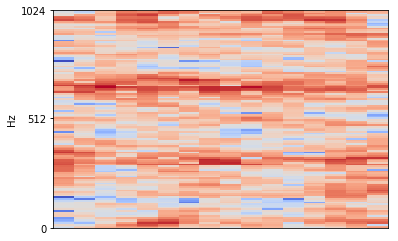

In [16]:

# f_max is the maximum frequency we would like to be looking at. Feature only present in this region. assume everything else is noise 
# we are dividing this region into 128 chuncks using the mel scale 
f_max = 1024   
n_mels = 128

# filter bank contains the most significant frequencies proposed by james for a few different voids
filter_set  = np.load("james_freqs.npy")

# visualise the mel spectrogram
Xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(data, n_mels = n_mels,fmax = f_max)))
librosa.display.specshow(Xt, y_axis = "mel", fmax = f_max)
#freqs= np.arange(0, 1 + n_fft / 2) * sr / n_fft

# lists the filters 
freqs = librosa.mel_frequencies(n_mels = n_mels, fmax = f_max)

print("Jame's frequencies are: \n", filter_bank)
print("The frequenceis in the spectrus are: \n", freqs)

(128, 16)
26.216696 -20.317747


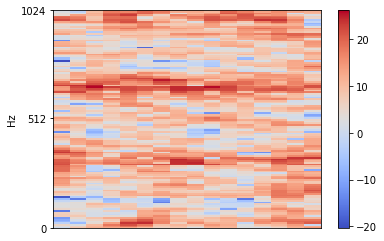

In [39]:
Xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(data, n_mels = n_mels,fmax = f_max)))
print(Xt.shape)
print(np.max(Xt),np.min(Xt))

librosa.display.specshow(Xt, y_axis = "mel", fmax = f_max)
plt.colorbar()

## 09/12/2020 

A number of functions are needed to create the input spectrograms. need to first create an empty spectrogram, put some impulses on it and smooth the inpulses somehow to make them into blobs. gausssian filters can be useful, to stretch them in the two directions. 

a normal operation sound needs to also be sampled. 

then the spectrograms are added together or the audios are added together in the time domain. adding in the time domain seem to make more sense as per the principle of superposition.


need to do an inverse short time fourier transform to achieve this. 

In [8]:
# defining functions for the audio synthesis
def find_matching_freqs(filter_bank,freqs):
    # this finds the matching frequency from the filter bank for each
    # freqeuency we want to generate 
    # output are the matching frequencies and the locations of them in the frequency bank 
    out = []
    indices =[]
    for freq in filter_bank: 
        a = min(freqs, key=lambda x:abs(x-freq))
        out.append(a)
        indices.append(int(np.where(freqs==a)[0]))
    return out, indices
    
    
def gen_window(win_size,indices,filter_shape):
    # this takes the locations of the required frequencies and place them in the center of an empty spectrogram 
    out = np.zeros(win_size)
    print(win_size)
    n2 = win_size[1]//2
    for i in indices:
        out[i,n2] = 4
    out = gaussian_filter(filter_shape=filter_shape,img=out)
    return out 

def gaussian_filter(img, filter_shape):
    # this does gaussir blurring on the generated spectrogram from gen_window
    return cv2.GaussianBlur(img,filter_shape,0)
    
    
_,indx=find_matching_freqs(filter_set[0], freqs)
    
win_size = (Xt.shape[0],16)  # this is 128*16, the size of a spectrogram.
gaussian_shape = (13,11)   # The first number is the horizontal spread, the second is the vertical spread, for the blur 
b = gen_window(win_size,indx,gaussian_shape)
    


(128, 16)


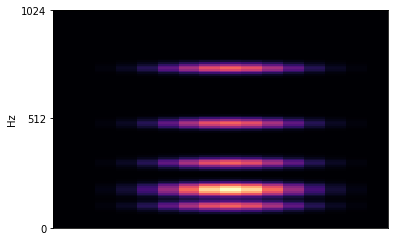

In [9]:
# visualising what the generated signal looks like 
librosa.display.specshow(b,y_axis="mel",fmax = f_max)

In [296]:
#feature_audio = librosa.core.istft(librosa.db_to_amplitude(b))
#X_recovered = librosa.core.istft(abs(librosa.stft(data)))

# reconstruct the audio from the spectrogram 
feature_audio = librosa.feature.inverse.mel_to_audio(b,fmax = f_max)*10
# This assumes the default hop length to be 512, which means each column represents 512/sr second
# so 512 * (w-1) should be the length of the recovered audio 
print(len(feature_audio))
print(512*(15))
print(len(feature_audio)/sr)
print(512/sr*15)
#print(librosa.db_to_amplitude(b*100)[:,7])

7680
7680
0.34829931972789113
0.3482993197278912


In [266]:
import IPython.display as ipd
print("The maximum and minimum amplitudes in the feature are %.2f and %.2f " %(max(feature_audio), min(feature_audio)))
print("The maximum and minimum amplitudes in the data are %.2f and %.2f " %(max(data), min(data)))
ipd.Audio(feature_audio, rate=sr)


The maximum and minimum amplitudes in the feature are 0.19 and -0.19 
The maximum and minimum amplitudes in the data are 0.78 and -0.91 


## 11/12/2021

The generated spectrogram sounds similar to a real void defect, according to dr coombs. this is promising and will be used to generate the traing samples. there needs to be a degree of randomness in this so introduce some algorithms to randomise the blurring process. this way the blobs can have different shapes. by doing this the model is exposed to training data of different types and can be good for preventing an overfit. 

In [267]:
# this first one is not used. 
def augument_with_features(x,b,n_mels= n_mels, f_max = f_max):
    xt = librosa.feature.melspectrogram(x,n_mels = n_mels,fmax = f_max)
    locs = []
    print(xt.shape)
    print(b.shape)
    for i in range(5):
        loc = np.random.randint(0,xt.shape[1]-b.shape[1])
        xt[:,loc:loc+b.shape[1]] += b
        locs.append(loc)
        
    return librosa.feature.inverse.mel_to_audio(xt,fmax = f_max), xt, locs


# this superimposes the time domain signal of the sound with a randomly selected segment in the background sound. 
def augument_time(x,feature, scale,n=5):
    locs = []
    x = librosa.util.normalize(x)
    feature = librosa.util.normalize(feature)* scale 
    
    # this is how many we are putting in 
    for i in range(n):
        # select random location
        loc = np.random.randint(0,len(x)-len(feature))
        # superposition
        x[loc:loc+len(feature)] += feature 
        locs.append(loc)
        
    # the returned audio is normalised 
    return librosa.util.normalize(x), locs
    

In [274]:
newsound,locs = augument_time(data,feature_audio,0.7)
print(max(newsound), min(newsound))
idp.Audio(newsound, rate=sr)

1.0 -0.9933884


## 11/12/2021

would like to visualise what the generated samples look like on a spectrogram. they should loook liek the origianl sound, with the addition of some void features. the void features should look like some blobs of relatively light amplitude on the spectroram at several frequency bands. The spectrogram of the original audio can be put side by side with the spectrogram of the generated signal to compare the differences. 

[118900, 193205, 25344, 130650, 207614]


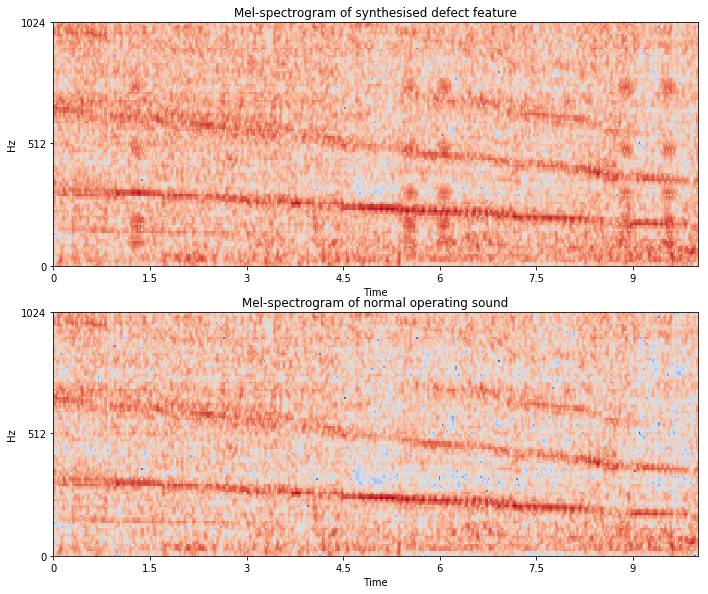

In [311]:
#viewing the resulting spectrogram 

fig, axs = plt.subplots(2,1,figsize=(10,8))
# covered_xt = librosa.feature.mfcc(newsound, n_mfcc=n_mels, fmax = f_max)

# takes the stft of the augumented sound and showing its spectrogram. features can be seen. 
recovered_xt = librosa.feature.melspectrogram(newsound, n_mels= n_mels, fmax= f_max)
librosa.display.specshow(librosa.power_to_db(recovered_xt), fmax = f_max, ax = axs[0],x_axis= "time", y_axis = "mel")

sf.write("./data/synthetic/7_with_void.wav", newsound, samplerate=sr)
#axs[0].scatter(np.array(locs)/sr, [200 for i in range(len(locs))],s=100, c = "b")
print(locs)
fig.tight_layout()
axs[0].title.set_text("Mel-spectrogram of synthesised defect feature")
axs[1].title.set_text("Mel-spectrogram of normal operating sound")

librosa.display.specshow(Xt, y_axis = "mel", fmax = f_max, ax = axs[1],x_axis= "time")


## 11/12/2020 

The generated spectrogram seems faily good. the voids at the 5 indicated locations can be seen. they appear as blobs with some randomness to their location and they are not too obvious on the spectrogram. According to Tim these are not too audible, and suggested that real voids sound much more prominent. if the detector can detect these samples they will be able to perform much better in real life due to higher signal to noise ratios. additionallly in real life the microphone can be directed and there can be wind proof attachments which reduce the noise furhter. in these pieces of audio the source of the audio is a go pro and would not really be good at cancelling noise. 

In [164]:
normal_data,sr = librosa.load("./data/youtube/wav/7_normal.wav")

## 15/12/2020 

the above experimentation seems promising so an actual dataset will be prepared using this algorithm. 2000 samples of normal operation sound should be sampled and saved for training purposes. another 600 pieces of various normal and void samples should be generated at different signal to noise ratios. This will form the vadiation set. the raw audios can be generated and saved, however later on they should be converted into spectrograms for better processing by the model. 





  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

  0%|▍                                                                                 | 1/200 [00:00<00:22,  8.88it/s]

  1%|▊                                                                                 | 2/200 [00:00<00:21,  9.07it/s]

  2%|█▏                                                                                | 3/200 [00:00<00:21,  9.03it/s]

  2%|██                                                                                | 5/200 [00:00<00:20,  9.75it/s]

  3%|██▍                                                                               | 6/200 [00:00<00:20,  9.63it/s]

  4%|███▎                                                                              | 8/200 [00:00<00:19,  9.98it/s]

  4%|███▋                                                                              | 9/200 [00:00<00:19,  9.68it/s]

  6%|████▍                    

 22%|█████████████████▍                                                               | 43/200 [00:03<00:12, 12.18it/s]

 22%|██████████████████▏                                                              | 45/200 [00:03<00:12, 12.04it/s]

 24%|███████████████████                                                              | 47/200 [00:04<00:13, 11.61it/s]

 24%|███████████████████▊                                                             | 49/200 [00:04<00:13, 11.41it/s]

 26%|████████████████████▋                                                            | 51/200 [00:04<00:15,  9.86it/s]

 26%|█████████████████████▍                                                           | 53/200 [00:04<00:15,  9.51it/s]

 27%|█████████████████████▊                                                           | 54/200 [00:04<00:16,  8.77it/s]

 28%|██████████████████████▋                                                          | 56/200 [00:05<00:15,  9.36it/s]

 29%|███████████████████████▍   

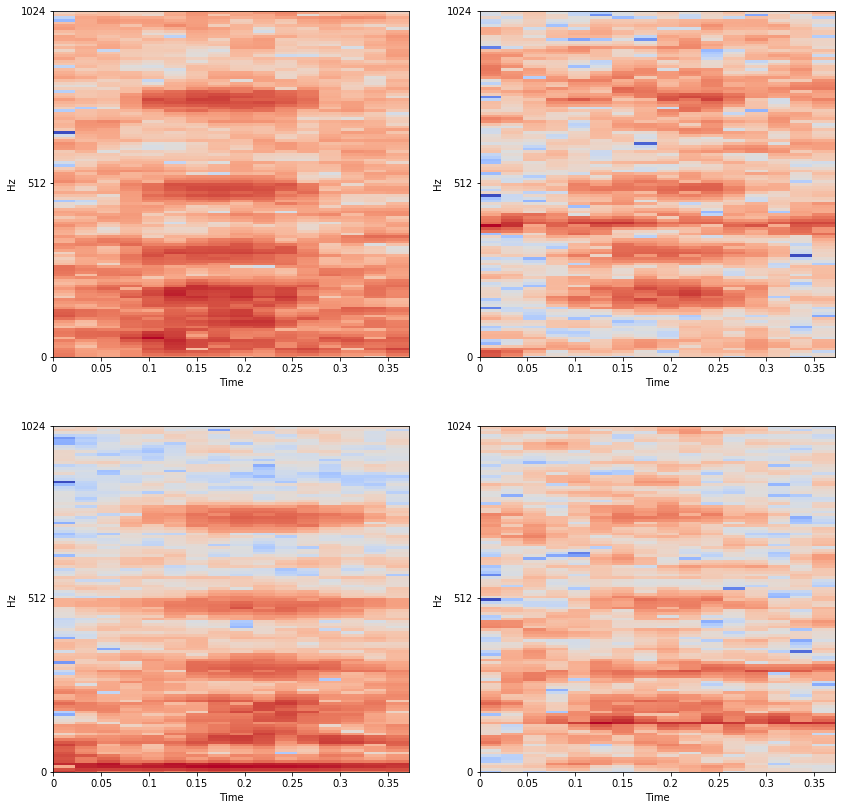

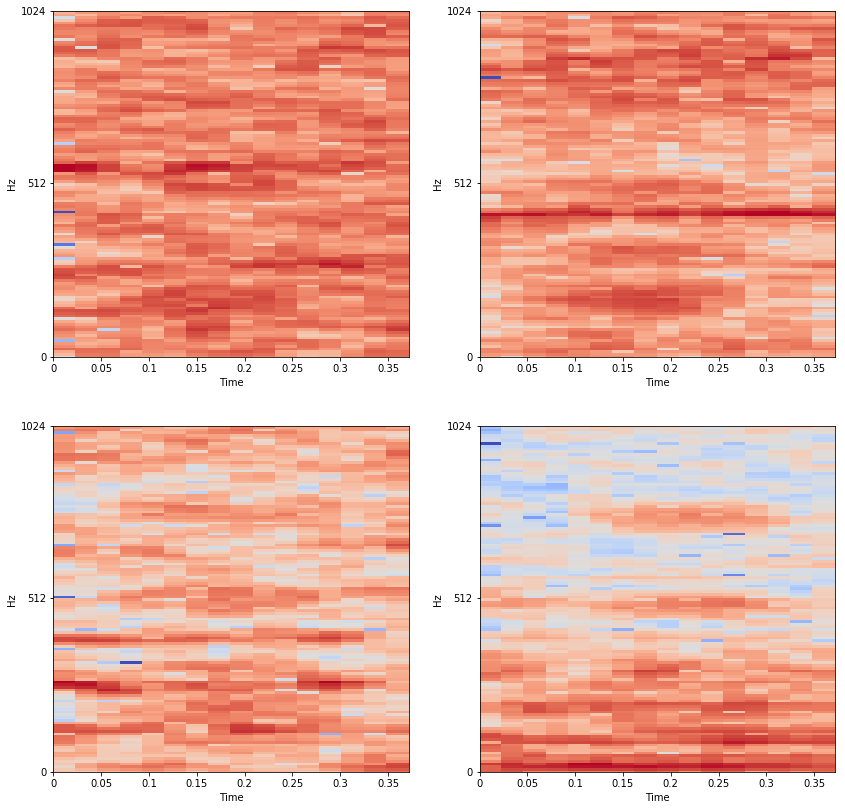

In [320]:
# this section generates the large number of training data as per above. 


import librosa 
import librosa.display
import cv2
import IPython.display as idp
import matplotlib.pyplot as plt 
import soundfile as sf
from tqdm import tqdm 
import numpy as np 
f_max = 1024
n_mels = 128
filter_set = np.load("james_freqs.npy")
freqs = librosa.mel_frequencies(n_mels = n_mels, fmax = f_max)

def find_matching_freqs(filter_bank,freqs):
    # This takes the target frequencies from the filter bank and finds the closest match from the available 
    # frequencies generated by the mel spectrogram
    out = []
    indices =[]
    for freq in filter_bank: 
        a = min(freqs, key=lambda x:abs(x-freq))
        out.append(a)
        indices.append(int(np.where(freqs==a)[0]))
    return out, indices
    
    
def gen_window(win_size,indices,filter_shape):
    # This generates a spectrogram slice using the given indices(where do we want the bright spot)
    # win_size defines the size of the slice. This should be (n_mels by desired length)
    out = np.zeros(win_size)
    n2 = win_size[1]//2
    for i in indices:
        out[i,n2] = 4
    out = cv2.GaussianBlur(out,filter_shape,0)
    return out 


def gen_feature(win_size, filter_shape,filter_bank):
        
    _,indx=find_matching_freqs(filter_bank, freqs)

    b = gen_window(win_size,indx,filter_shape)
    
    
    return librosa.feature.inverse.mel_to_audio(b,fmax = f_max)
    
    
def add_feature(x,feature, scale):
    x = librosa.util.normalize(x)
    feature = librosa.util.normalize(feature)* scale 
    
    loc = int((len(x)-len(feature))/2)+np.random.randint(-int(len(feature)/8),int(len(feature)/8))
    x[loc:loc+len(feature)] += feature

    
    return librosa.util.normalize(x)


# this is the function 
def gen_void_samples(normal_data, frequency_set, n=1, snr=1.0, verbose = False, wh=13, h = 13, v = 11, clip_len=16, train = True):
    
    if train:
        sound_path = "./data/synthetic/train_sounds/nsr"+str(int(1/snr))
    else: 
        sound_path = "./data/synthetic/test_sounds/nsr"+str(int(1/snr))
    x_list = []
    n_frames=clip_len*512-1
    
    for i in tqdm(range(n)):
        frequency_bank = frequency_set[np.random.randint(0,len(frequency_set))]
        loc = np.random.randint(0,len(normal_data)-n_frames)
        normal_sample = normal_data[loc:loc+n_frames]
        wh = np.random.choice([9,11,13])
        feature = gen_feature(win_size = (n_mels,wh), filter_shape= (h,v),filter_bank=frequency_bank)
        x = add_feature(normal_sample,feature,snr)
        sf.write(sound_path+"/"+str(i)+".wav", x, sr, subtype='PCM_24')

        if i < 4:
            x_list.append(x)

    if verbose:
        fig, axs = plt.subplots(2,2, figsize = (14,14))
        for j in range(len(x_list)):
            x1 = x_list[j]
            xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(x1, n_mels = n_mels,fmax = f_max)))
            librosa.display.specshow(xt, y_axis = "mel", x_axis = "time", fmax = f_max, ax = axs[j//2][j%2])  
    return 

x=gen_void_samples(normal_data, filter_set,n = 200,verbose=True, snr=1, train = False)
x=gen_void_samples(normal_data, filter_set,n = 200,verbose=True, snr=0.5, train = False)


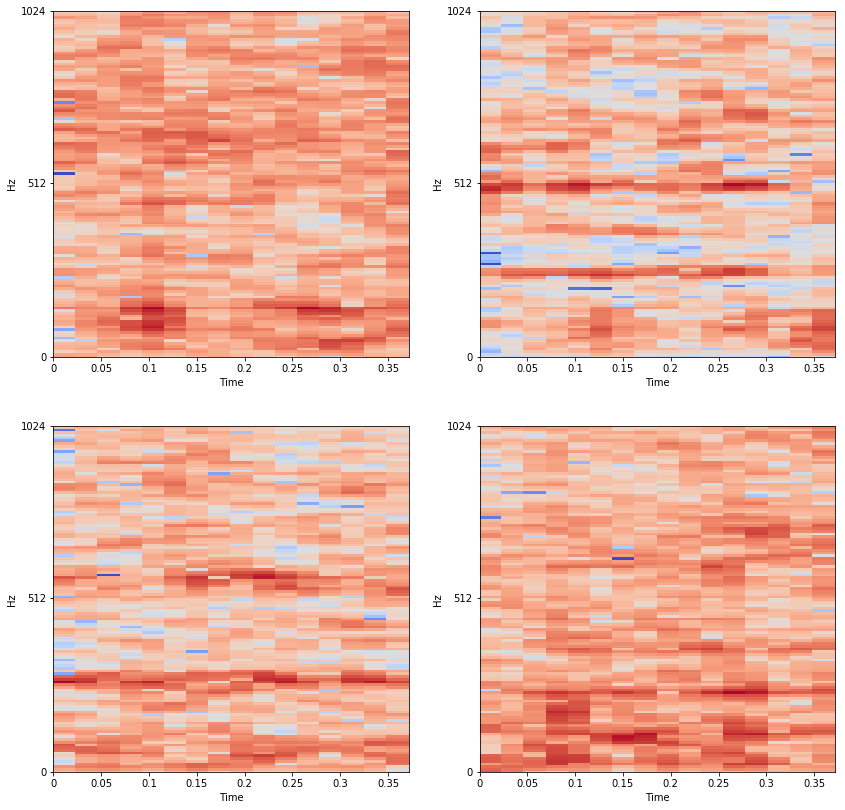

In [309]:

def sample_normal(normal_sound,n, verbose = False, train = True):
    # This generates normal sounding data slices. hopefully these can be distinguished from the 
    # abnormal set. 
    # We can use this to actually test supervised learning methods as well
    
    if train:
        save_path = "./data/synthetic/train_sounds/normal/"
        ref_audio  = "./data/synthetic/train_sounds/nsr1/0.wav"
    else: 
        save_path = "./data/synthetic/test_sounds/normal/"
        ref_audio  = "./data/synthetic/test_sounds/nsr1/0.wav"
    x_list = []
    
    for i in range(n):
        ref_data,sr  = librosa.load(ref_audio)
        loc = np.random.randint(0,len(normal_sound)-len(ref_data))
        
        normal_slice = normal_sound[loc:loc+len(ref_data)]
        sf.write(save_path+"n"+str(i)+".wav", normal_slice, sr, subtype='PCM_24')
        if i <4: 
            x_list.append(normal_slice)
        
    if verbose: 
        fig, axs = plt.subplots(2,2, figsize = (14,14))
        for j in range(len(x_list)):
            x1 = x_list[j]
            xt = librosa.power_to_db(abs(librosa.feature.melspectrogram(x1, n_mels = n_mels,fmax = f_max)))
            librosa.display.specshow(xt, y_axis = "mel", x_axis = "time", fmax = f_max, ax = axs[j//2][j%2])  
    return 
    return 

sample_normal(normal_data,200,verbose=True, train = False)


    

## 14/12/2020 

these generated samples look to be pretty good. the normal operation sound look normal and the void samples appear to have some blobs at certain frequencies. this is good as they are not too obvious by eye, meaning that the detector should be better than humans if it can detect those sample.s the low snr samples dont look very different to the normal operation sound, as per expected. these will be very difficult to detect. 

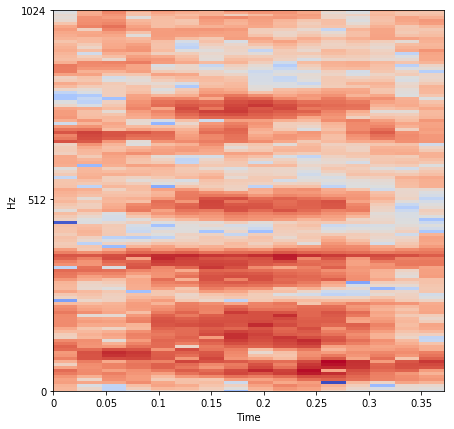

In [33]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
f_max = 1024
n_mels = 128

path  = "./data/synthetic/train_sounds/nsr1/19.wav"
path2 = "./data/synthetic/train_sounds/nsr2/19.wav"
x1,_ = librosa.load(path)
x2,_ = librosa.load(path2)

xt1 = librosa.power_to_db(abs(librosa.feature.melspectrogram(x1, n_mels = n_mels,fmax = f_max)))
xt2 = librosa.power_to_db(abs(librosa.feature.melspectrogram(x2, n_mels = n_mels,fmax = f_max)))

librosa.display.specshow(xt1, y_axis = "mel", x_axis = "time", fmax = f_max, ax = ax)


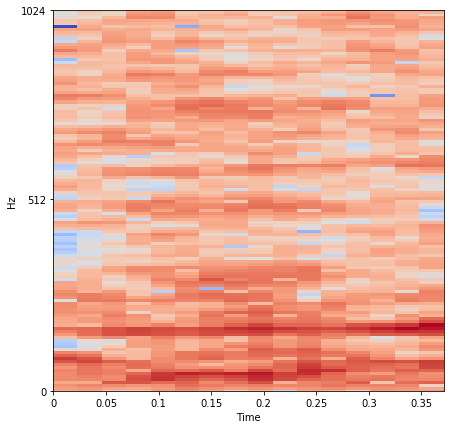

In [34]:
fig, ax = plt.subplots(1,1, figsize = (7,7))

librosa.display.specshow(xt2, y_axis = "mel", x_axis = "time", fmax = f_max, ax = ax)